# Mars 2020 SHERLOC Data Processing Pipeline (for data in PDS archive)

This program is hosted at: https://github.com/kenwilliford/SHERLOC_DPP_PDS

Description: This Jupyter Notebook will process and visualize publicly available data (stored in the PDS Geosciences Node and the public Mars 2020 images website) from the NASA Mars 2020 SHERLOC instrument, an ultraviolet fluorescence and Raman spectrometer and imaging system mounted on the robotic arm of the Perseverance rover. More information about SHERLOC and its data can be found at the SHERLOC archive on the PDS Geosciences Node here: https://pds-geosciences.wustl.edu/missions/mars2020/sherloc.htm. This notebook assumes some familiarity with SHERLOC and its data structure as described in the SHERLOC PDS User Guide: https://pds-geosciences.wustl.edu/m2020/urn-nasa-pds-mars2020_sherloc/document/sherloc_user_guide.pdf.

Instructions:

0. Ensure spectral calibration table (spec_cal.csv) is in the current working directory (same folder as this notebook).
1. Ensure data files are in a subfolder labelled as in the PDS archive (e.g. /sol_00861).
    - RRS (dark-subtracted spectra) file (e.g. ss__0861_0743401635_545rrs__0420000srlc11374w104cgnj02.csv)
    - RLS (laser shot position table) file (e.g. ss__0861_0743401635_545rls__0420000srlc11374_104___j02.csv)
    - ACI image (e.g. SC3_0861_0743401530_113ECM_N0420000SRLC11374_0000LMJ01.PNG)
2. Define variables in PARAMETERS cell below.
3. Sequentially read descriptions and run each cell below, or (if confident with parameter settings, etc.) simply Run All Cells to transform data, remove cosmic rays, baseline fit and subtract (both before and after cosmic ray removal), and attempt Gaussian peak fitting in the spectral region where Raman peaks from common minerals occur. 

This notebook was created by Ken Williford and tested using Python 3.11.4

MIT License

Copyright (c) 2024 Ken Williford

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
# Import necessary libraries

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
import os
from pybaselines import Baseline, utils
from scipy import stats
from scipy.optimize import curve_fit, differential_evolution
from tqdm.notebook import tqdm
import skimage.draw

plt.rcParams['figure.facecolor'] = 'white' # set parameters so plots have a white background

Set parameters for data processing below. The RRS file includes the dark-subtracted spectra and is located in the 'SHERLOC Processed Spectroscopy data collection' of the PDS Geosciences Node organized by sol similar to the following, corresponding to sol 861: https://pds-geosciences.wustl.edu/m2020/urn-nasa-pds-mars2020_sherloc/data_processed/sol_00861/.

In [2]:
# PARAMETERS

target = 'Dragons_Egg_Lake' #this is the name of the rock target on Mars
sol = 861 # this is the sol on which the scan occured
scan = 'detail_1' # this is the name of the scan (usually either detail_1, detail_2, or survey_1296)
rrs_filename = 'ss__0861_0743401635_545rrs__0420000srlc11374w104cgnj02.csv'

Define and read the spectral calibration file spec_cal.csv which should be located in the working directory and contains the wavelength (nm) and Raman shift (cm$^{-1}$) values for each pixel (actually a binned set of pixels, or "channel") on the SHERLOC detector. 

In [3]:
# defining the spectral calibration file
spec_cal = 'spec_cal.csv'

# read the spectral calibration csv
df_spec_cal = pd.read_csv(spec_cal)

Next we generate the path to the RRS data file, define a subdirectory for output files (named for the Mars target in question) and further subdirectories for test plots (generated by the code for quality assurance) and spectra plots (for any downstream manual plotting of spectra from this target). 

In [4]:
# Using zfill to ensure the sol number is at least 5 digits long
sol_str = str(sol).zfill(5)

# Locating the rrs (dark-subtracted spectra) file
rrs_data_path = f"sol_{sol_str}/{rrs_filename}"

# defining output directory
output_dir = target # Define the output directory based on the target
os.makedirs(output_dir, exist_ok=True) # This will create the directory if it doesn't exist

# Create 'test_plots' directory within output_dir
test_plots_dir = f"{output_dir}/test_plots"
os.makedirs(test_plots_dir, exist_ok=True)

# Create 'spectra_plots' directory within output_dir
spectra_plots_dir = f"{output_dir}/spectra_plots"
os.makedirs(spectra_plots_dir, exist_ok=True)

The data in the original RRS file are organized with columns corresponding to detector channels and rows containing intensity values for each point in the scan (i.e. each row contains a spectrum). We want to transpose the data so that the spectra are in columns (one for each point in the scan). Let's do this for each of the three spectral regions -- R1 (Raman; 250 to 281.92 nm or 225 to 4760 cm$^{-1}$), R2 (fluorescence; 281.98 to 337.78 nm) and R3 (fluorescence 337.82 to 355.47 nm) -- and export the transformed "raw" (really dark-subtracted, laser-normalized) data as four csvs (one for each spectral region and a fourth called R123 with all three regions concatenated). These files will be exported to the output directory named for the Mars target created in the previous step.

In [5]:
### 1. Reading and exporting the raw data for spectral regions R1 (Raman), R2 and R3 (fluorescence)

# Read the R1 raw data from the .csv file at rrs_data_path
R1_raw = pd.read_csv(rrs_data_path, skiprows=4, nrows=100).T

# Slice R1 to 225 to 4760 cm-1 (or 250 to 281.92 nm)
R1_raw_df_all = R1_raw.reset_index(drop=True)
R1_raw_df_slice = R1_raw_df_all[51:574]

# replace index of raw_data_R1 with raman_shift wavenumbers between 225 and 4760 in df_spec_cal
R1_df_spec_cal_slice = df_spec_cal.iloc[51:574, 2]

# creating dataframe for raw data between 500 and 4760 cm-1
R1_raw_df = R1_raw_df_slice.set_index(R1_df_spec_cal_slice)

# exporting R1 raw data to .csv
R1_raw_output_file = output_dir + "/" + str(sol) + '_' + str(target) + '_' + str(scan) + '_R1_raw.csv'
R1_raw_df.to_csv(R1_raw_output_file, sep=",")

# Read the second 100 rows of the raw data from the .csv file at rrs_data_path
R2_raw = pd.read_csv(rrs_data_path, skiprows=106, nrows=100).T

# Slice R2 to 281.98 and 337.78 nm
R2_raw_df_all = R2_raw.reset_index(drop=True)
R2_raw_df_slice = R2_raw_df_all[574:1677]

# replace index of raw_data_R2 with wavelength between 282 and 337.8 nm in df_spec_cal
R2_df_spec_cal_slice = df_spec_cal.iloc[574:1677, 1]

# creating dataframe for raw data between 281.98 and 337.78 nm
R2_raw_df = R2_raw_df_slice.set_index(R2_df_spec_cal_slice)

# exporting R2 raw data to .csv
R2_raw_output_file = output_dir + "/" + str(sol) + '_' + str(target) + '_' + str(scan) + '_R2_raw.csv'
R2_raw_df.to_csv(R2_raw_output_file, sep=",")

# Read the third 100 rows of the raw data from the .csv file at rrs_data_path
R3_raw = pd.read_csv(rrs_data_path, skiprows=208, nrows=100).T

# Slice R3 to 337.82 to 355.47 nm
R3_raw_df_all = R3_raw.reset_index(drop=True)
R3_raw_df_slice = R3_raw_df_all[1677:2098]

# replace index of raw_data_R3 with wavelength between 337.82 to 355.47 nm in df_spec_cal
R3_df_spec_cal_slice = df_spec_cal.iloc[1677:2098, 1]

# creating dataframe for raw data between 337.82 to 355.47 nm
R3_raw_df = R3_raw_df_slice.set_index(R3_df_spec_cal_slice)

# exporting R3 raw data to .csv
R3_raw_output_file = output_dir + "/" + str(sol) + '_' + str(target) + '_' + str(scan) + '_R3_raw.csv'
R3_raw_df.to_csv(R3_raw_output_file, sep=",")

# Concatenate R1, R2, and R3 dataframes
R123_raw_df = pd.concat([R1_raw_df, R2_raw_df, R3_raw_df])

# Identify the rows in df_spec_cal from 51 to 2098
R123_df_spec_cal_slice = df_spec_cal.iloc[51:2098, 1]  # assuming 'wavelength' is the second column, hence index 1

# Replace the index of R123_raw_df with the selected wavelengths
R123_raw_df.set_index(R123_df_spec_cal_slice, inplace=True)

# exporting R123 raw data to .csv
R123_raw_output_file = output_dir + "/" + str(sol) + '_' + str(target) + '_' + str(scan) + '_R123_raw.csv'
R123_raw_df.to_csv(R123_raw_output_file, sep=",")

Next, we will apply a despiking algorithm to remove cosmic ray events from the data. When cosmic rays impinge upon the SHERLOC detector signal is registered on the pixel(s) that were impacted. If this occurs during acquisition of the active frame, this leads to a positive spike in the data over the region impacted by the cosmic ray event, and if it occurs during acquisition of the dark frame, this leads to a negative spike (since the dark frame is subtracted from the active frame to generate our working data). Often cosmic ray events occur over only one to a few pixels, making them relatively straightforward to distinguish from Raman peaks that (due to the spectral resolution of the instrument) occur over five or more pixels on the detector. Some cosmic ray events also occur over five or more pixels on the detector, though, making them difficult to distinguish from Raman peaks. As such, algorithms used so far (including the one below) to automatically remove cosmic rays also affect true Raman peaks. For this reason, peak detection and mineral identification routines later in the code are performed on the baseline-subtracted spectra from which cosmic rays have not been automatically removed.

<Figure size 800x1000 with 0 Axes>

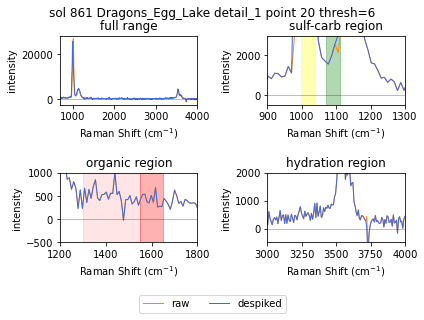

In [6]:
### 2. Despiking (removing cosmic rays) ###

# despiking using Whitaker and Hayes 2018 approach modified for python as described by Nicolas Coca here:
# https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22

# This modified Z-score method uses the median (M) and median absolute deviation (MAD) 
# rather than the mean and standard deviation:

# z(i) = 0.6745 (x(i)-M) / MAD

# where the MAD = median(|x-M|) and |…| represents the absolute value. 
# Both the median and the MAD are robust measures of the central tendency and dispersion, respectively. 
# The multiplier 0.6745 is the 0.75th quartile of the standard normal distribution, 
# to which the MAD converges⁴.

def modified_z_score(y):
    median_y = np.median(y)
    mad_y = np.median(np.abs(y - median_y))
    modified_z_scores = 0.6745 * (y - median_y) / mad_y
    return modified_z_scores

spikethresh = 6

def fixer(y, m):
    threshold = spikethresh
    spikes = abs(modified_z_score(np.diff(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-m, i+1+m)
            w = w[(w >= 0) & (w < len(spikes))]  # Limit indices in w to be within the valid range
            w2 = w[spikes[w] == 0]
            if len(w2) > 0:  # Check if w2 is not empty before calculating the mean
                y_out.iloc[i] = np.mean(y.iloc[w2])
    return y_out

m = 3

# Apply modified_z_score and fixer to each column of raw_R1_data_slice
R1_despiked_df = R1_raw_df.apply(lambda y: pd.Series(fixer(y, m)), axis=0)

# Apply modified_z_score and fixer to each column of raw_R1_data_slice
R2_despiked_df = R2_raw_df.apply(lambda y: pd.Series(fixer(y, m)), axis=0)

# Apply modified_z_score and fixer to each column of raw_R1_data_slice
R3_despiked_df = R3_raw_df.apply(lambda y: pd.Series(fixer(y, m)), axis=0)

# Apply modified_z_score and fixer to each column of raw_R1_data_slice
R123_despiked_df = R123_raw_df.apply(lambda y: pd.Series(fixer(y, m)), axis=0)

### test plot despiking results ###

# select a test_point representing a point in the scan for comparison of raw and processed data
test_point = 20

# making a new dataframe from raw and processed spectra from the selected point in the scan
R1_despiked_comp = pd.concat([R1_raw_df[test_point], R1_despiked_df[test_point]], 
                          axis=1, keys=['point ' + str(test_point) + ' raw', 
                                        'point ' + str(test_point) + ' despiked'])

# plotting raw and despiked data from test point

line_colors = ['darkorange', 'royalblue']
line_styles = ['solid', 'solid']
line_widths = [1, 1]
line_labels = ['raw', 'despiked']

def plot_with_styles(ax, data, styles, widths, colors):
    for i, (style, width, color) in enumerate(zip(styles, widths, colors)):
        ax.plot(data.iloc[:, i], linestyle=style, linewidth=width, color=color)

plt.figure(figsize=(8, 10), dpi=100)
fig, axs = plt.subplots(2, 2)
fig.suptitle('sol ' + str(sol) + ' ' + 
             target + ' ' + scan + ' point ' + 
             str(test_point) + ' thresh=' + str(spikethresh))

plot_with_styles(axs[0, 0], R1_despiked_comp, line_styles, line_widths, line_colors)
axs[0, 0].set_title('full range')
axs[0, 0].axhline(0, alpha=0.5, color='black', lw=0.5)
plot_with_styles(axs[0, 1], R1_despiked_comp, line_styles, line_widths, line_colors)
axs[0, 0].set_xlim([700, 4000])
axs[0, 1].set_title('sulf-carb region')
axs[0, 1].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[0, 1].axvspan(998, 1038, alpha=0.3, color='yellow', label='sulf')
axs[0, 1].axvspan(1070, 1110, alpha=0.3, color='green', label='carb')
axs[0, 1].set_ylim([-500, 3000])
axs[0, 1].set_xlim([900, 1300])
plot_with_styles(axs[1, 0], R1_despiked_comp, line_styles, line_widths, line_colors)
axs[1, 0].set_title('organic region')
axs[1, 0].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[1, 0].axvspan(1300, 1550, alpha=0.1, color='red')
axs[1, 0].axvspan(1550, 1650, alpha=0.3, color='red')
axs[1, 0].set_xlim([1200, 1800])
axs[1, 0].set_ylim([-500, 1000])
plot_with_styles(axs[1, 1], R1_despiked_comp, line_styles, line_widths, line_colors)
axs[1, 1].set_title('hydration region')
axs[1, 1].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[1, 1].set_xlim([3000, 4000])
axs[1, 1].set_ylim([-500, 2000])

for ax in axs.flat:
    ax.set(xlabel='Raman Shift (cm$^{-1}$)', ylabel='intensity')
    
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.legend(labels = line_labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(line_labels))

plt.show()

fig.savefig(test_plots_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + str(test_point) + 
            '_thresh' + str(spikethresh) + '_R1_despike_test.png', 
            bbox_inches="tight", dpi=500)
    
plt.close()

After reviewing test plot(s) (and adjusting cosmic ray removal parameters and reprocessing as desired), export the despiked data to csv.

In [7]:
### 3. Exporting despiked data

# exporting despiked R1 data
R1_despiked_df.to_csv(output_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + 'R1_despiked.csv', sep=",")

# exporting despiked R2 data
R2_despiked_df.to_csv(output_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + 'R2_despiked.csv', sep=",")

# exporting despiked R3 data
R3_despiked_df.to_csv(output_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + 'R3_despiked.csv', sep=",")

# exporting despiked R123 data
R123_despiked_df.to_csv(output_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + 'R123_despiked.csv', sep=",")

Next, we apply a baseline fit and subtraction routine to the R1 (Raman) data using pybaselines. The code below uses the Adaptive Smoothness Penalized Least Squares (asPLS) algorithm. More information on this algorithm can be found here: Zhang, F., et al. Baseline correction for infrared spectra using adaptive smoothness parameter penalized least squares method. Spectroscopy Letters, 2020, 53(3), 222-233. and here: https://pybaselines.readthedocs.io/en/latest/api/pybaselines/whittaker/index.html. This method includes the definition of a lambda (baselam) that determines the smoothness of the overall baseline fit, but also alpha which is a local modifier to lambda for regions of the spectrum that features Raman peaks (peak_alpha) and those that typically do not (non_peak_alpha), to reduce the degree to which the baseline fit is affected by Raman peaks in the spectrum. This code applies the baseline fitting and subtraction iteratively over each column (each a spectrum from a single scan point) in the "raw" and "despiked" data tables generated from the preceding code and produces test plots showing the original spectrum, the baseline fit, and the baseline-subtracted spectrum from one point (test_point) in the scan. Use these test plots to evaluate the results of the baseline fit and subtraction, and when satisfied, move on to the next step.

<Figure size 800x1000 with 0 Axes>

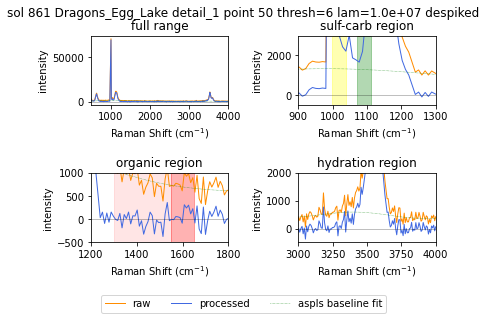

<Figure size 800x1000 with 0 Axes>

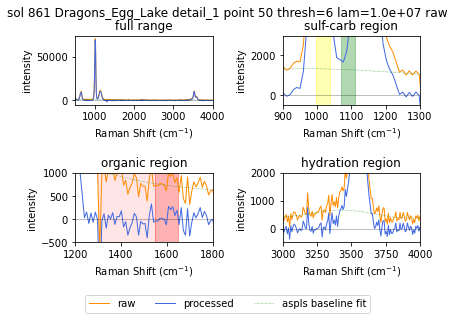

In [8]:
### 4. Baseline fit and subtraction of R1 data using Adaptive Smoothness Penalized Least Squares (asPLS). ###

# Initialize baseline_fitter
baseline_fitter = Baseline(R1_raw_df.index, check_finite=False)

baselam = 1e7

# Define peak and non-peak regions
peak_regions = [
    (600, 1130),
    (1300, 1720),
    (3000, 3800)
]

non_peak_alpha = 1.0
peak_alpha = 0.01

def create_custom_penalty_weight_vector(spectrum, peak_regions, non_peak_alpha, peak_alpha):
    w = np.full(len(spectrum), non_peak_alpha)
    for start, end in peak_regions:
        mask = (spectrum.index >= start) & (spectrum.index <= end)
        w[mask] = peak_alpha
    return w

def fit_baseline(y, diff_order=2):
    w = create_custom_penalty_weight_vector(y, peak_regions, non_peak_alpha, peak_alpha)
    bkg = baseline_fitter.aspls(y, lam=baselam, diff_order=diff_order, weights=w)[0]
    return bkg

# Define fit and subtract function
def fit_and_subtract_baseline(y, diff_order=2):
    bkg = fit_baseline(y, diff_order)
    return y - bkg

# generate dataframe with baseline fit of raw data
R1_raw_baseline_fit = R1_raw_df.apply(fit_baseline, axis=0)
# generate dataframe with baseline subtraction of raw data
R1_raw_baseline_sub = R1_raw_df.apply(fit_and_subtract_baseline, axis=0)

# generate dataframe with baseline fit of despiked data
R1_despiked_baseline_fit = R1_despiked_df.apply(fit_baseline, axis=0)
# generate dataframe with baseline subtraction of despiked data
R1_despiked_baseline_sub = R1_despiked_df.apply(fit_and_subtract_baseline, axis=0)

### test plot baseline fit and subtraction results

# select a test_point representing a point in the scan for comparison of baselined raw and despiked data
test_point = 50

### WITH BASELINE-SUBTRACTED DESPIKED DATA ###

# making a new dataframe from despiked and baseline subtracted despiked spectra from the selected point in the scan
R1_proc_comp_despiked = pd.concat([R1_despiked_df[test_point], 
                       R1_despiked_baseline_sub[test_point], 
                       R1_despiked_baseline_fit[test_point]], 
                      axis=1, 
                      keys=['point ' + str(test_point) + ' raw', 
                            'point ' + str(test_point) + ' processed', 
                            'point ' + str(test_point) + ' aspls baseline fit'])

# plotting the comparison

line_colors = ['darkorange', 'royalblue', 'green']
line_styles = ['solid', 'solid', 'dotted']
line_widths = [1, 1, 0.5]
line_labels = ['raw', 'processed', 'aspls baseline fit']

def plot_with_styles(ax, data, styles, widths, colors):
    for i, (style, width, color) in enumerate(zip(styles, widths, colors)):
        ax.plot(data.iloc[:, i], linestyle=style, linewidth=width, color=color)

plt.figure(figsize=(8, 10), dpi=100)
fig, axs = plt.subplots(2, 2)
fig.suptitle('sol ' + str(sol) + ' ' + target + ' ' + scan + ' point ' + 
             str(test_point) + ' thresh=' + str(spikethresh) + 
             ' lam=' + "{:.1e}".format(baselam) + ' despiked')

plot_with_styles(axs[0, 0], R1_proc_comp_despiked, line_styles, line_widths, line_colors)
axs[0, 0].set_title('full range')
axs[0, 0].axhline(0, alpha=0.5, color='black', lw=0.5)
plot_with_styles(axs[0, 1], R1_proc_comp_despiked, line_styles, line_widths, line_colors)
axs[0, 0].set_xlim([500, 4000])
axs[0, 1].set_title('sulf-carb region')
axs[0, 1].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[0, 1].axvspan(998, 1038, alpha=0.3, color='yellow', label='sulf')
axs[0, 1].axvspan(1070, 1110, alpha=0.3, color='green', label='carb')
axs[0, 1].set_ylim([-500, 3000])
axs[0, 1].set_xlim([900, 1300])
plot_with_styles(axs[1, 0], R1_proc_comp_despiked, line_styles, line_widths, line_colors)
axs[1, 0].set_title('organic region')
axs[1, 0].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[1, 0].axvspan(1300, 1550, alpha=0.1, color='red')
axs[1, 0].axvspan(1550, 1650, alpha=0.3, color='red')
axs[1, 0].set_xlim([1200, 1800])
axs[1, 0].set_ylim([-500, 1000])
plot_with_styles(axs[1, 1], R1_proc_comp_despiked, line_styles, line_widths, line_colors)
axs[1, 1].set_title('hydration region')
axs[1, 1].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[1, 1].set_xlim([3000, 4000])
axs[1, 1].set_ylim([-500, 2000])

for ax in axs.flat:
    ax.set(xlabel='Raman Shift (cm$^{-1}$)', ylabel='intensity')
    
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.legend(labels = line_labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(line_labels))

plt.show()

fig.savefig(test_plots_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + str(test_point) + '_R1_despiked_baseline_test.png', 
            bbox_inches="tight", dpi=300)
    
plt.close()

### WITH BASELINE-SUBTRACTED RAW DATA ###

# making a new dataframe from raw and processed spectra from the selected point in the scan
R1_proc_comp_raw = pd.concat([R1_raw_df[test_point], 
                       R1_raw_baseline_sub[test_point], 
                       R1_raw_baseline_fit[test_point]], 
                      axis=1, 
                      keys=['point ' + str(test_point) + ' raw', 
                            'point ' + str(test_point) + ' processed', 
                            'point ' + str(test_point) + ' aspls baseline fit'])

# plotting the comparison

line_colors = ['darkorange', 'royalblue', 'green']
line_styles = ['solid', 'solid', 'dotted']
line_widths = [1, 1, 0.5]
line_labels = ['raw', 'processed', 'aspls baseline fit']

def plot_with_styles(ax, data, styles, widths, colors):
    for i, (style, width, color) in enumerate(zip(styles, widths, colors)):
        ax.plot(data.iloc[:, i], linestyle=style, linewidth=width, color=color)

plt.figure(figsize=(8, 10), dpi=100)
fig, axs = plt.subplots(2, 2)
fig.suptitle('sol ' + str(sol) + ' ' + target + ' ' + scan + ' point ' + 
             str(test_point) + ' thresh=' + str(spikethresh) + 
             ' lam=' + "{:.1e}".format(baselam) + ' raw')

plot_with_styles(axs[0, 0], R1_proc_comp_raw, line_styles, line_widths, line_colors)
axs[0, 0].set_title('full range')
axs[0, 0].axhline(0, alpha=0.5, color='black', lw=0.5)
plot_with_styles(axs[0, 1], R1_proc_comp_raw, line_styles, line_widths, line_colors)
axs[0, 0].set_xlim([500, 4000])
axs[0, 1].set_title('sulf-carb region')
axs[0, 1].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[0, 1].axvspan(998, 1038, alpha=0.3, color='yellow', label='sulf')
axs[0, 1].axvspan(1070, 1110, alpha=0.3, color='green', label='carb')
axs[0, 1].set_ylim([-500, 3000])
axs[0, 1].set_xlim([900, 1300])
plot_with_styles(axs[1, 0], R1_proc_comp_raw, line_styles, line_widths, line_colors)
axs[1, 0].set_title('organic region')
axs[1, 0].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[1, 0].axvspan(1300, 1550, alpha=0.1, color='red')
axs[1, 0].axvspan(1550, 1650, alpha=0.3, color='red')
axs[1, 0].set_xlim([1200, 1800])
axs[1, 0].set_ylim([-500, 1000])
plot_with_styles(axs[1, 1], R1_proc_comp_raw, line_styles, line_widths, line_colors)
axs[1, 1].set_title('hydration region')
axs[1, 1].axhline(0, alpha=0.5, color='black', lw=0.5)
axs[1, 1].set_xlim([3000, 4000])
axs[1, 1].set_ylim([-500, 2000])

for ax in axs.flat:
    ax.set(xlabel='Raman Shift (cm$^{-1}$)', ylabel='intensity')
    
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.legend(labels = line_labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(line_labels))

plt.show()

fig.savefig(test_plots_dir + "/" + str(sol) + '_' + target + '_' + scan + '_' + str(test_point) + '_R1_raw_baseline_test.png', 
            bbox_inches="tight", dpi=300)
    
plt.close()

Once we're happy with the results of baseline fit and subtraction, let's export the "baselined" "raw" and "despiked" data for R1 as separate csvs.

In [9]:
### 5. Exporting baseline subtracted R1 data

# export baseline subtracted raw data
R1_raw_baseline_sub.to_csv(output_dir + "/" + str(sol) + '_' + str(target) + '_' + scan + '_' + 'R1_raw_baselined.csv', sep=",")

# export baseline subtracted despiked data
R1_despiked_baseline_sub.to_csv(output_dir + "/" + str(sol) + '_' + str(target) + '_' + scan + '_' + 'R1_despiked_baselined.csv', sep=",")

# Modeling multiple Gaussian peaks in the Raman spectral range for common mineral peaks (700 to 1200 cm$^{-1}$)

Now that the data are in the appropriate format, and baselines have been fit and subtracted, we can use Gaussian peak fitting to detect possible Raman features in the spectra. This approach uses differential_evolution from scipy.optimize to model up to max_peaks Gaussian peaks with acceptable FWHM between fwhm_range=(min, max) in the spectral range fit_range=(min, max), plots any fitted peaks along with the original spectrum, calculates the mean, amplitude, FWHM, and SNR of each fitted peak and captures these parameters for each fit in a DataFrame and exports to csv. Plots with fitted peaks are exported as 300 dpi png files to a subfolder.

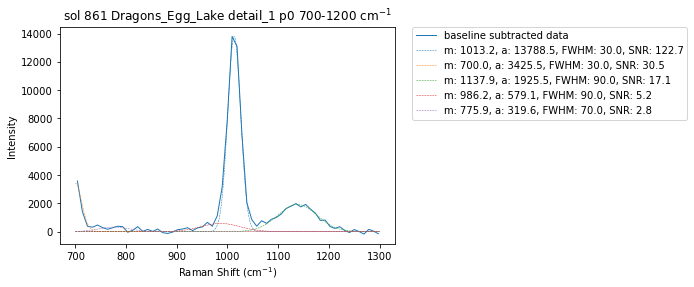

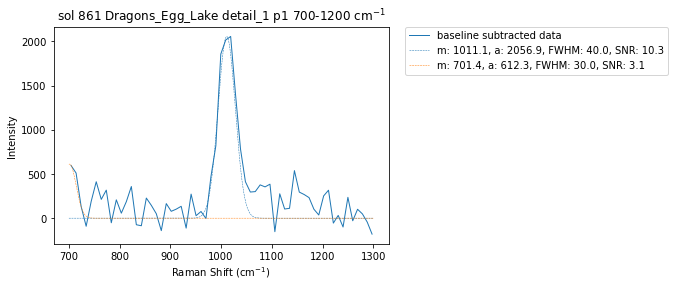

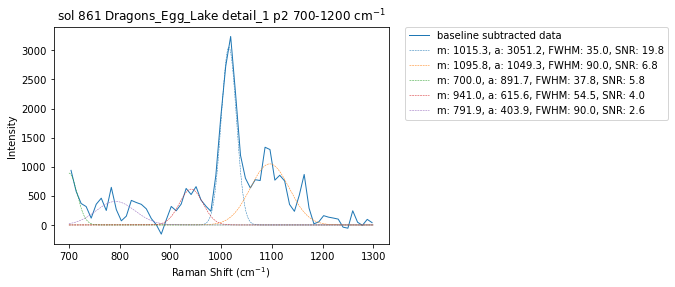

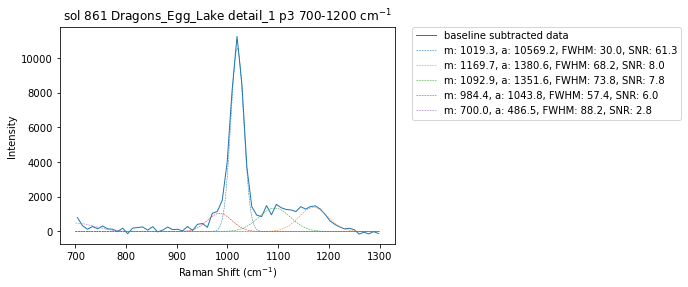

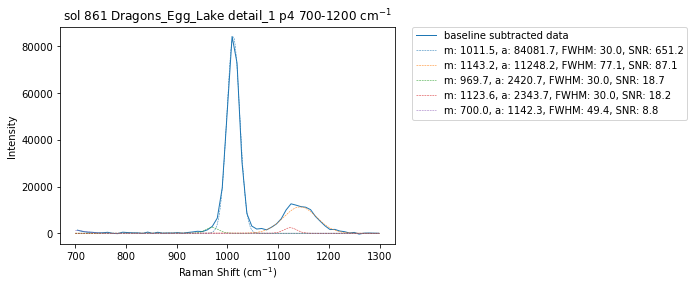

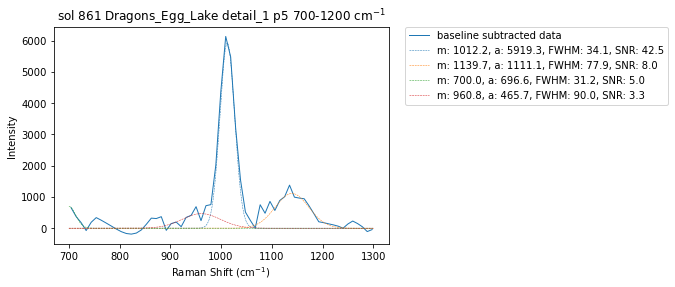

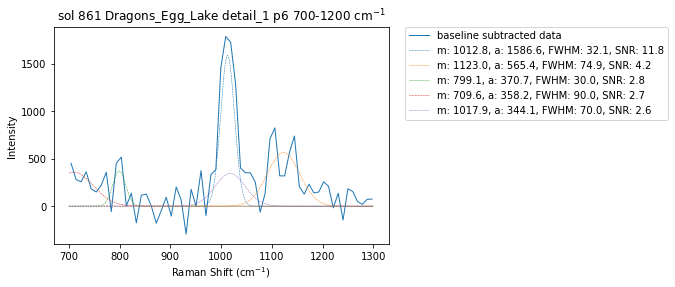

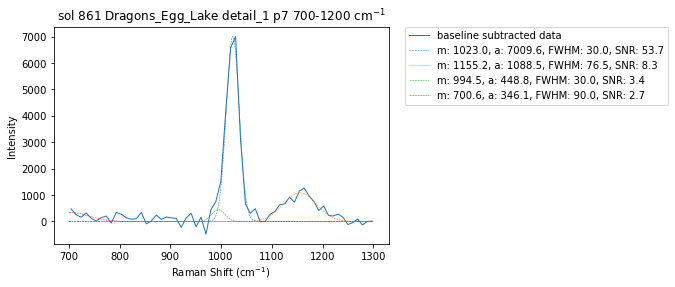

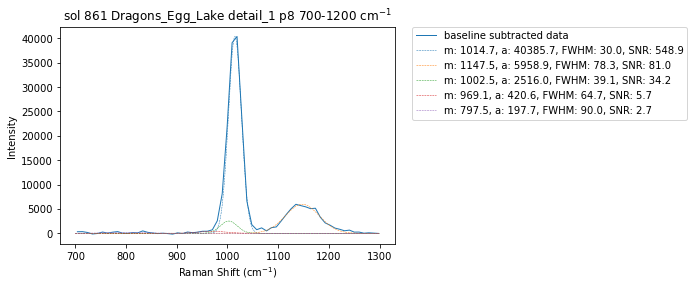

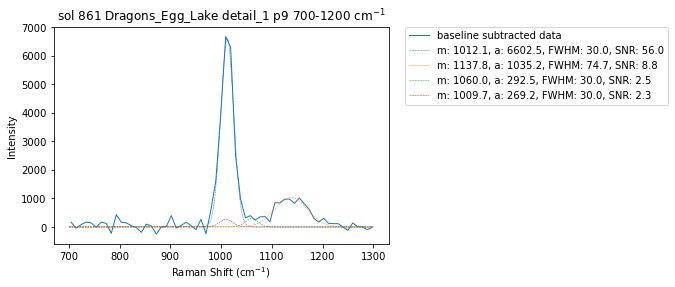

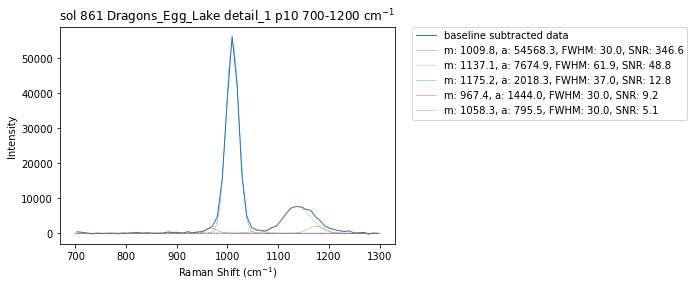

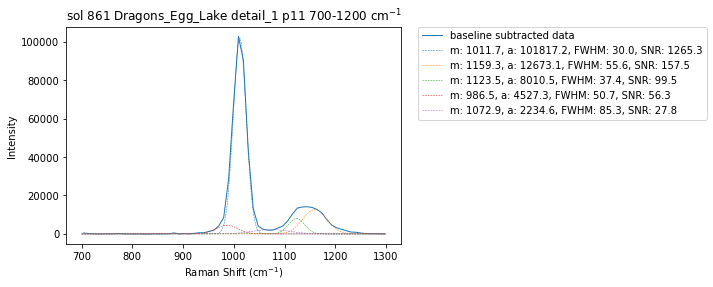

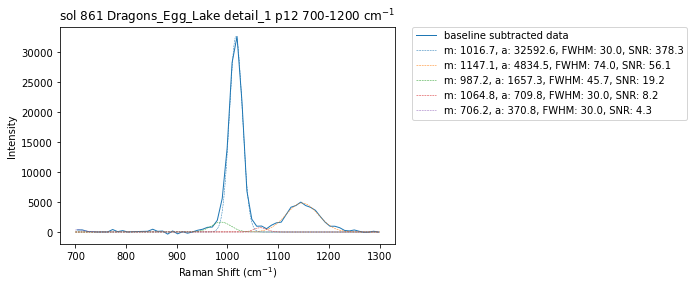

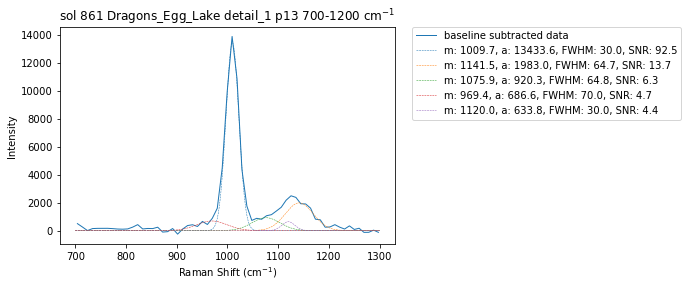

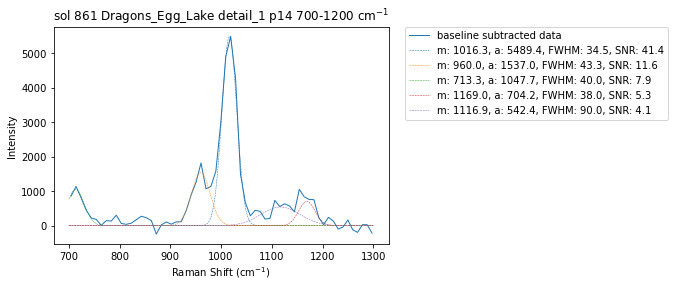

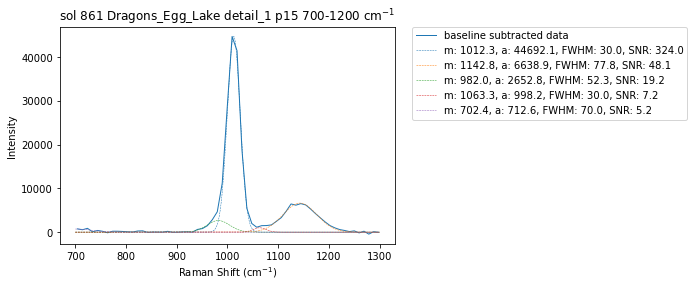

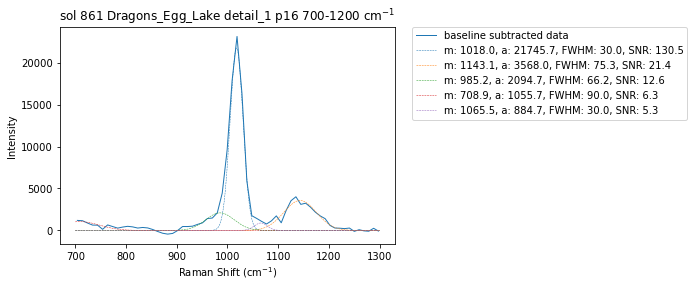

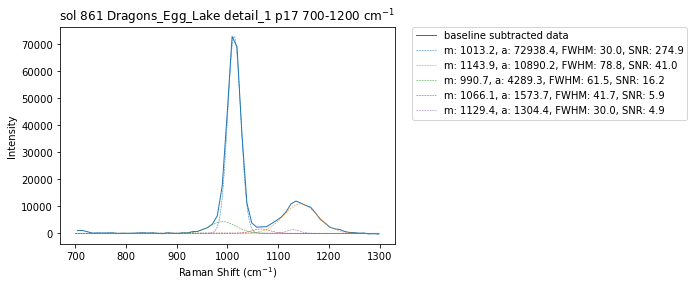

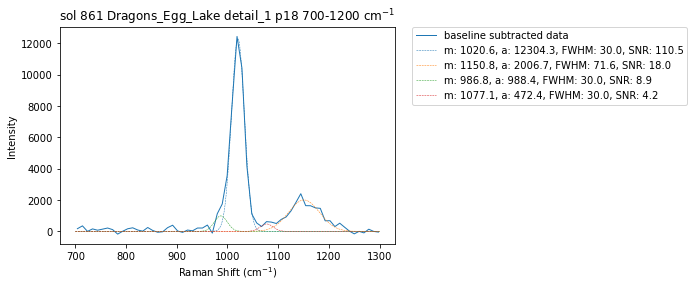

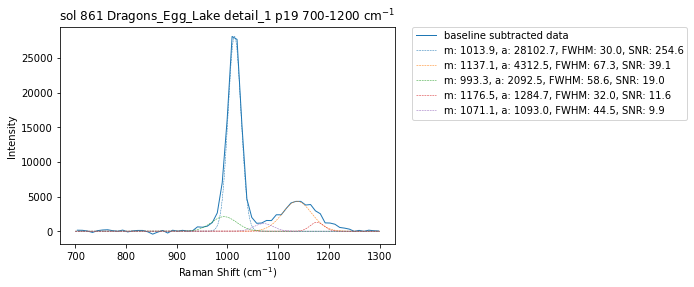

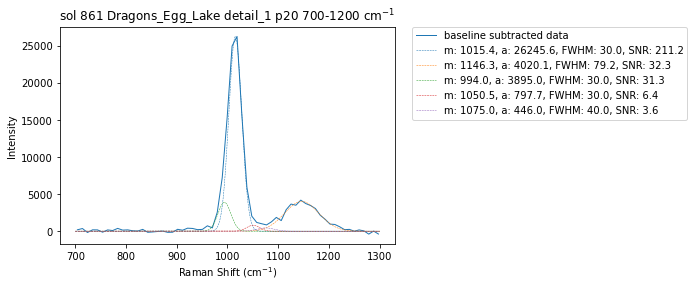

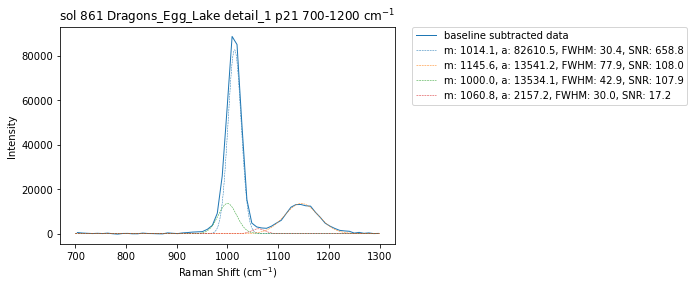

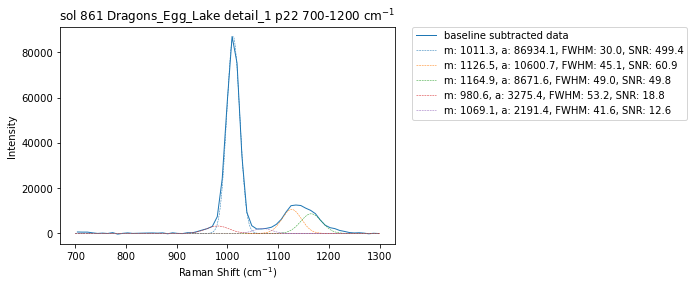

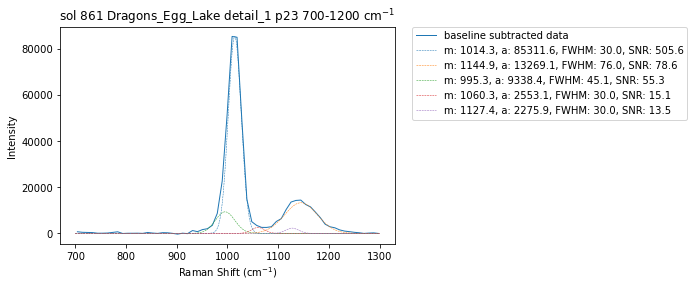

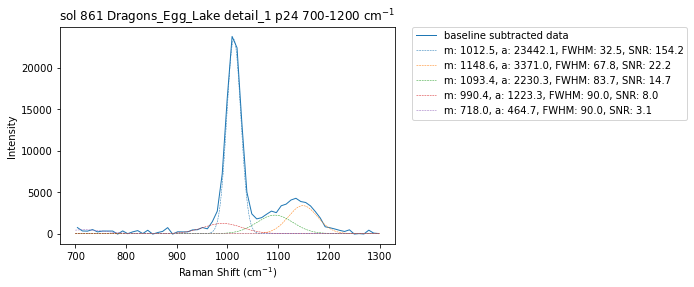

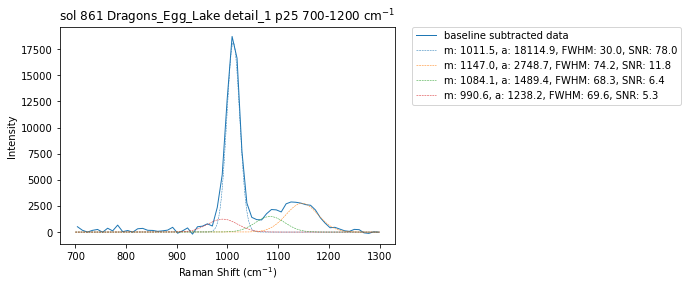

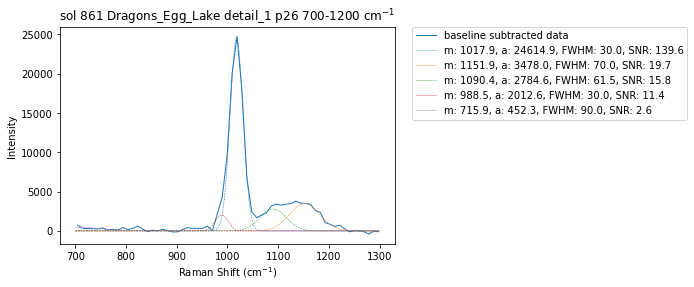

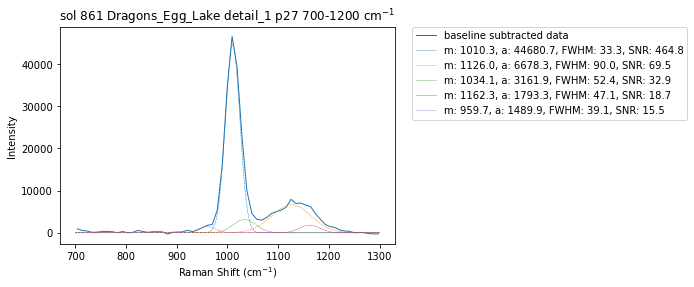

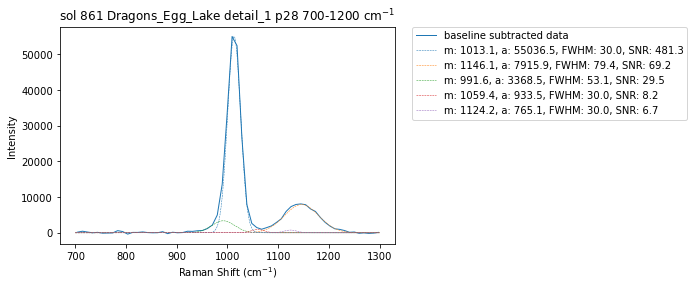

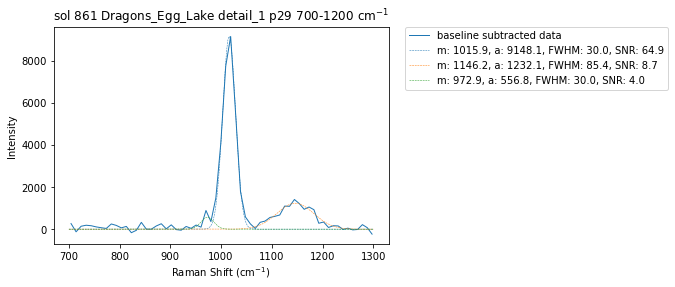

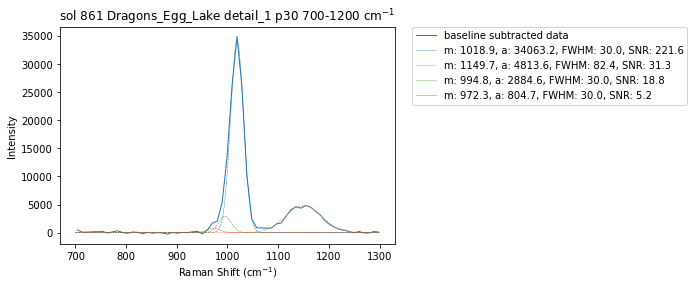

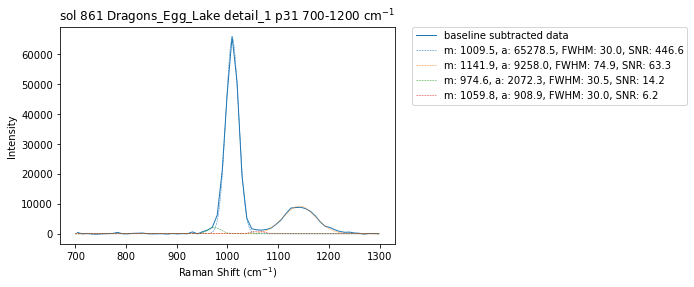

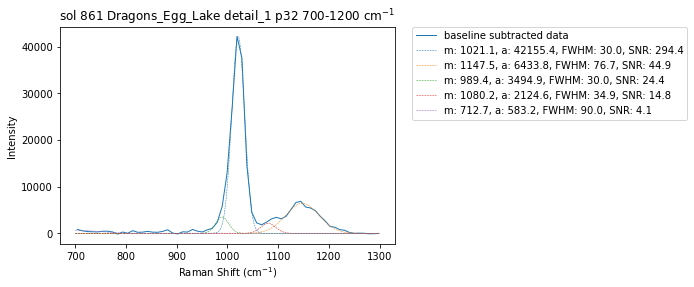

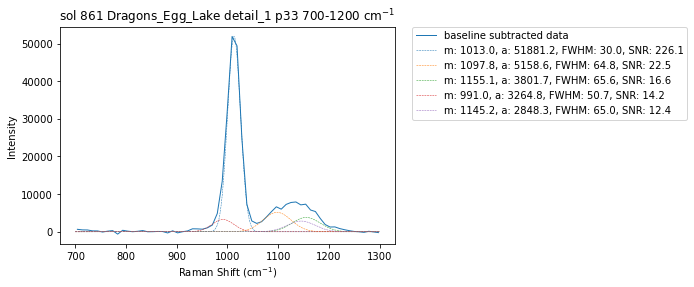

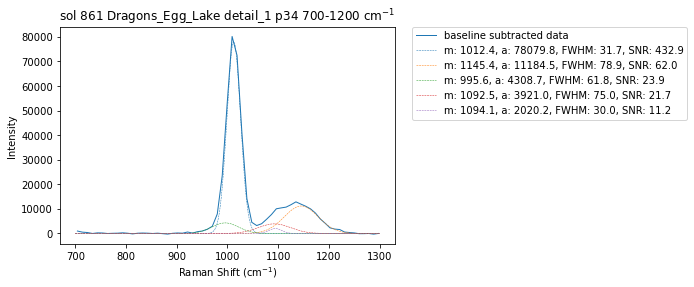

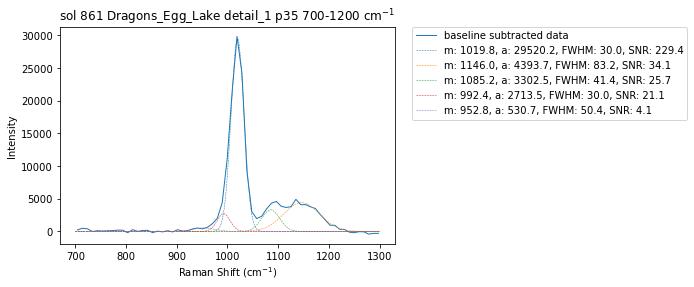

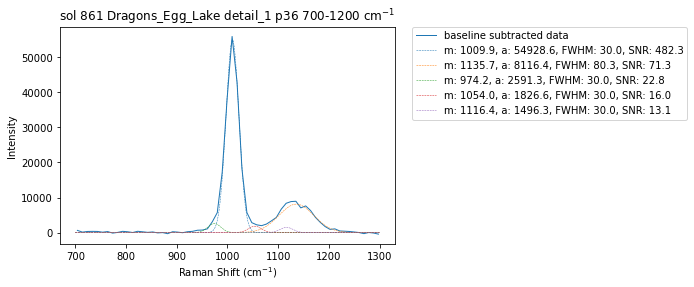

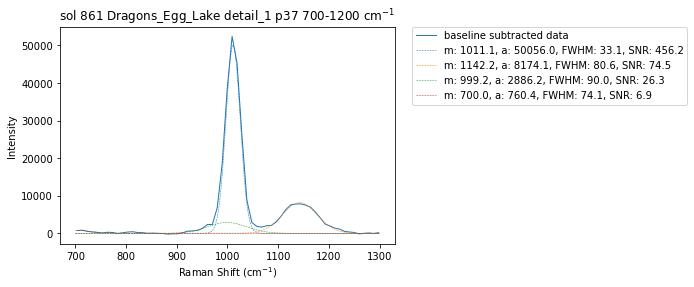

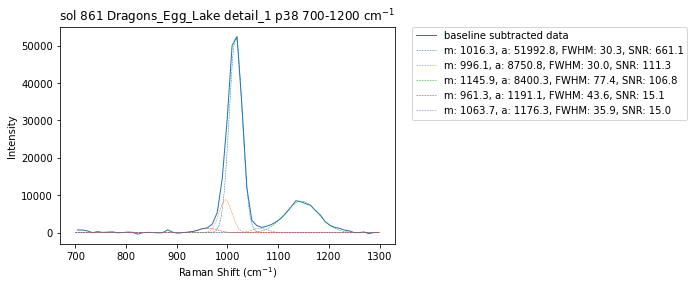

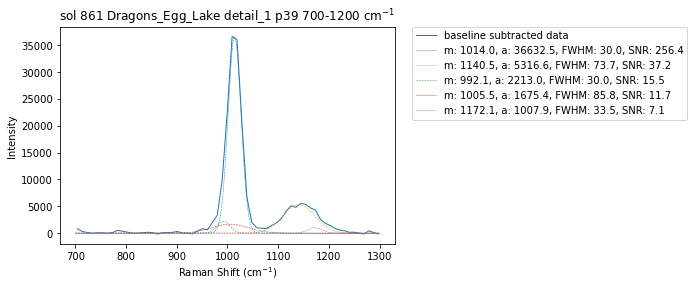

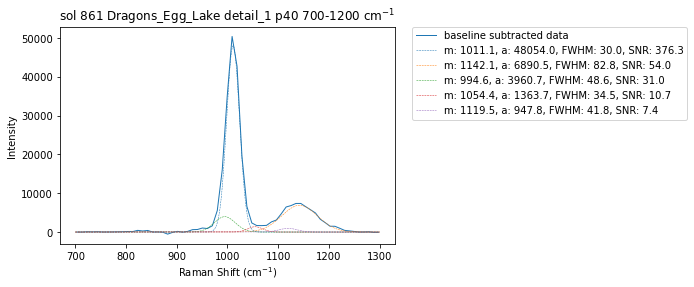

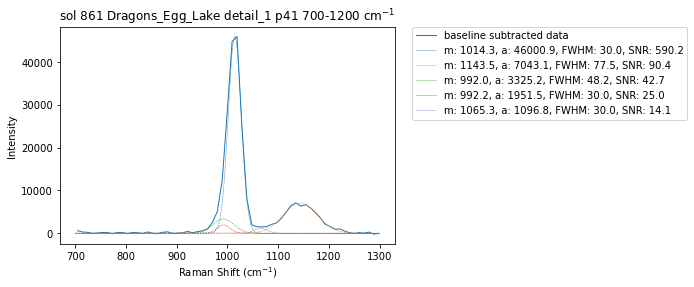

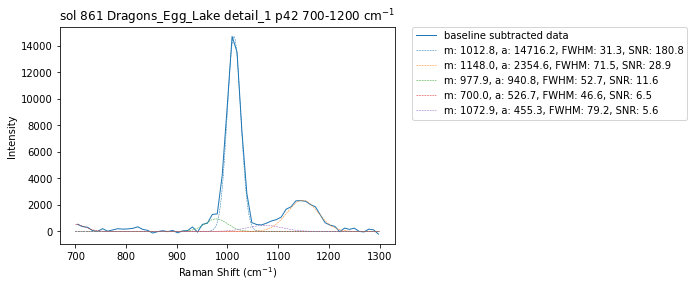

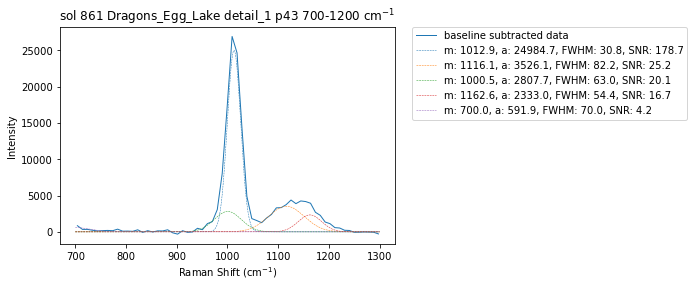

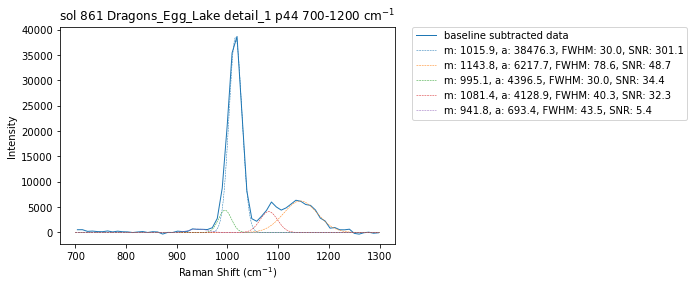

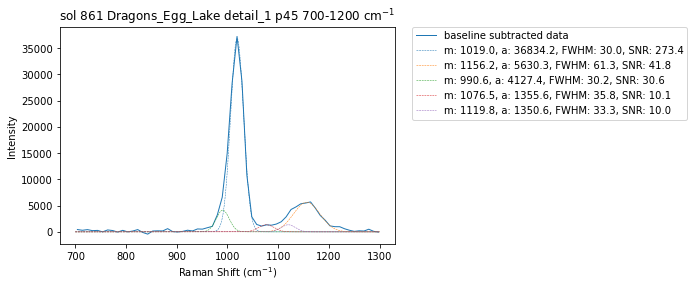

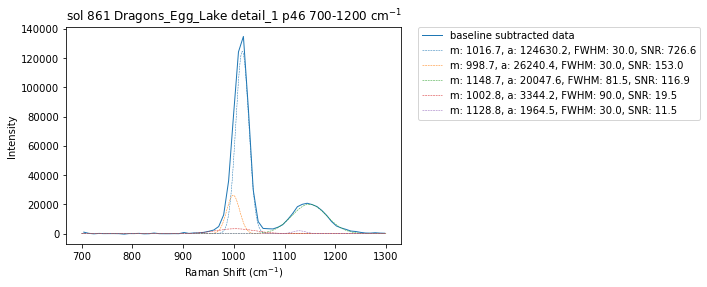

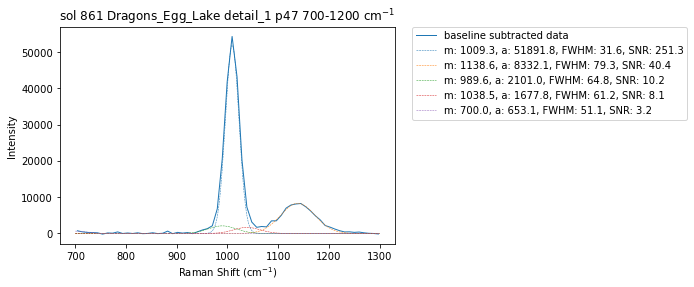

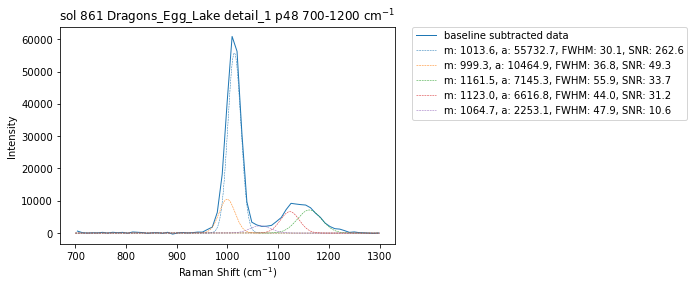

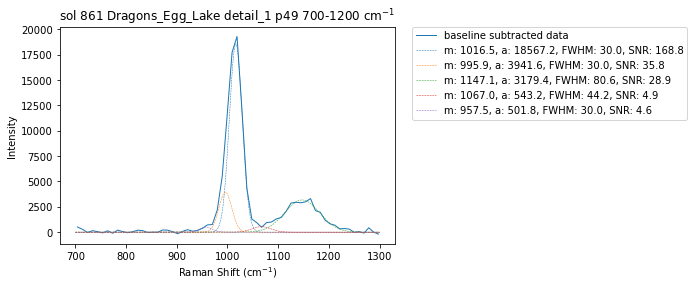

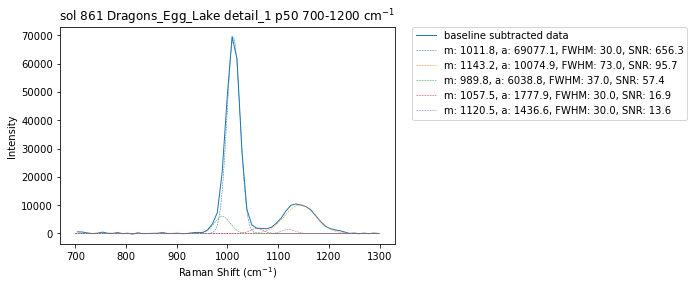

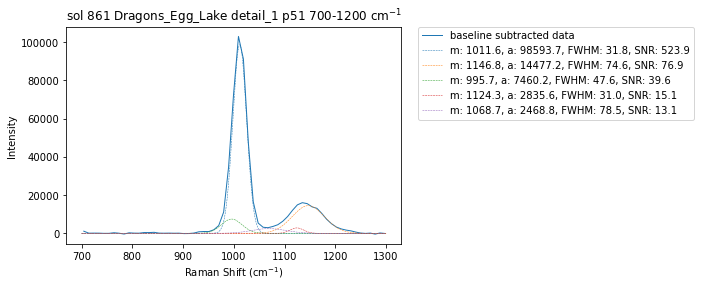

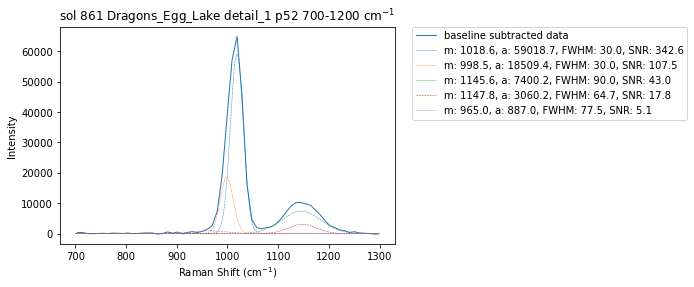

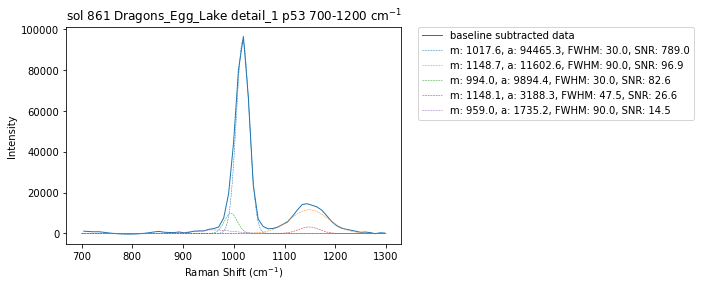

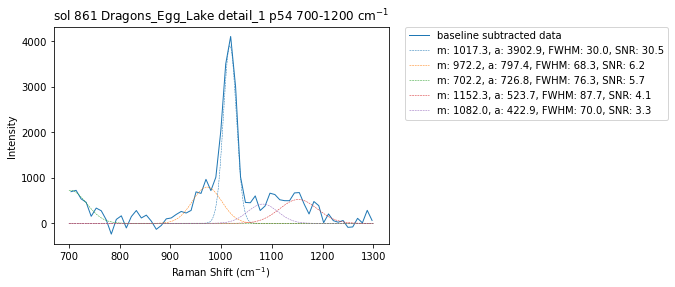

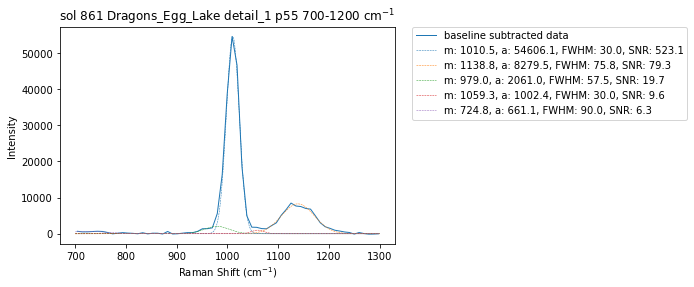

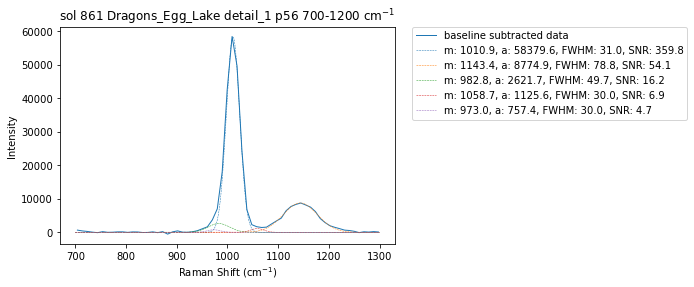

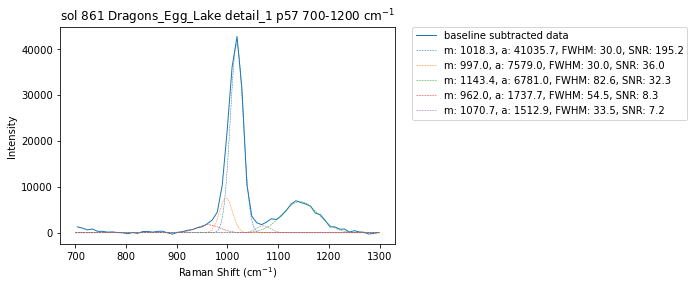

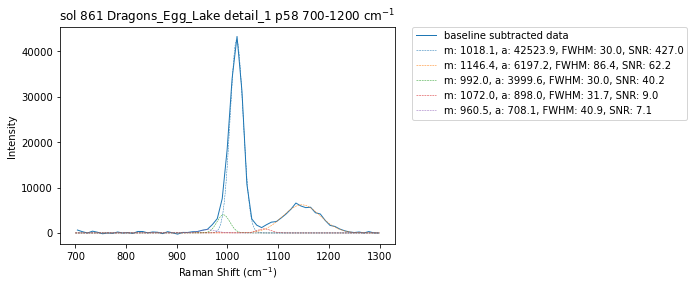

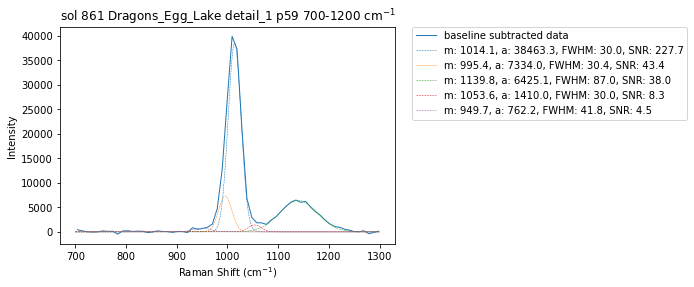

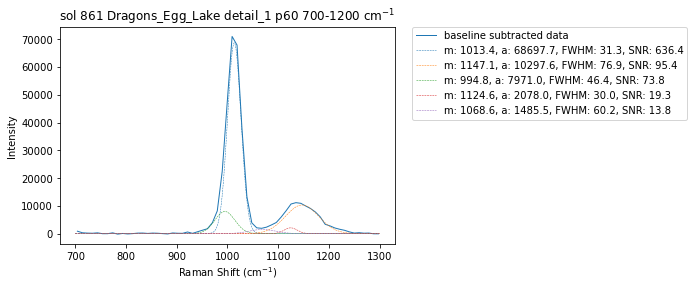

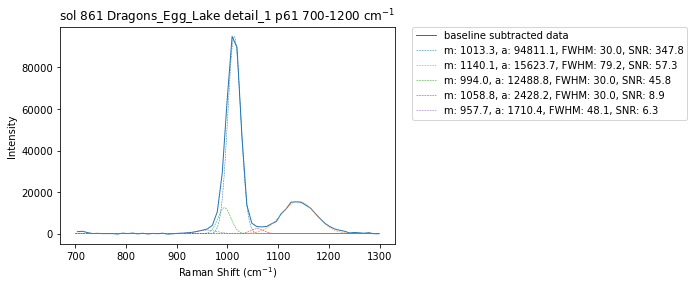

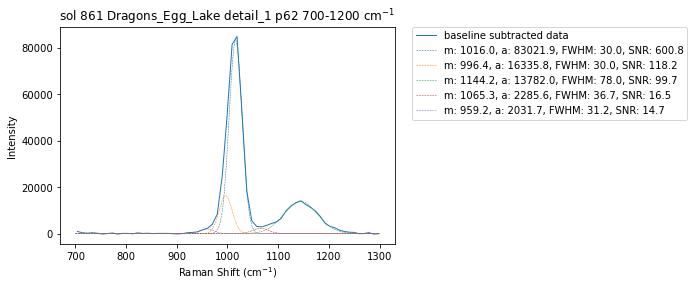

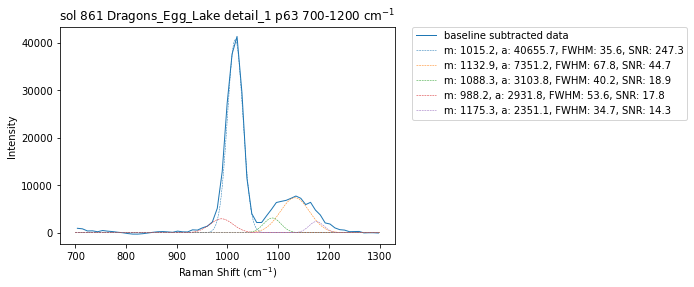

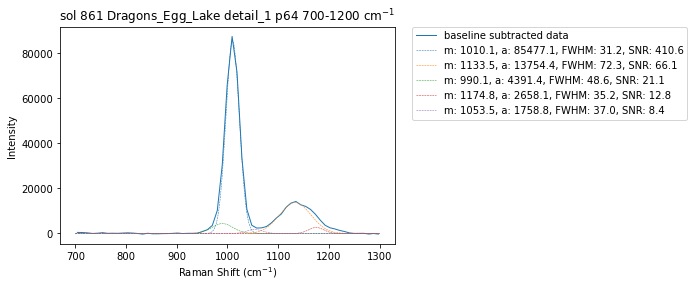

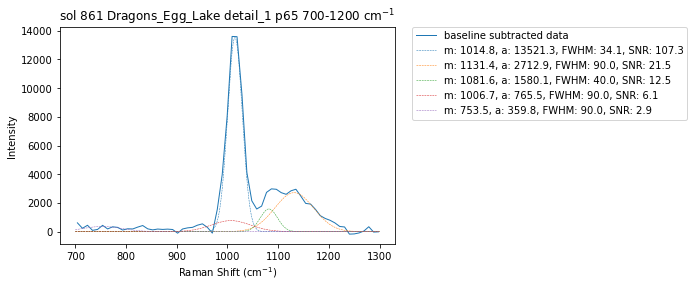

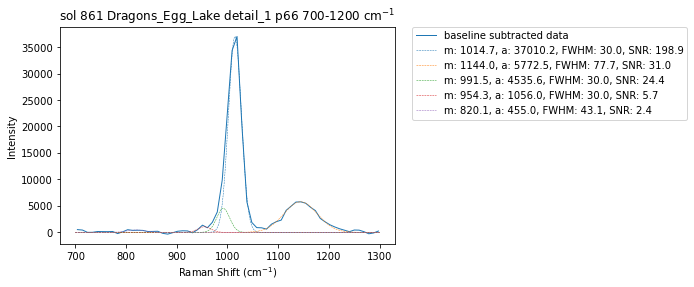

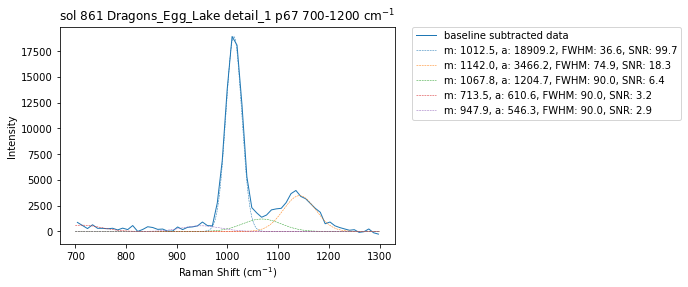

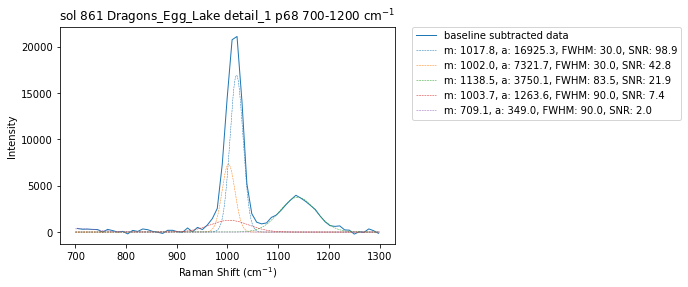

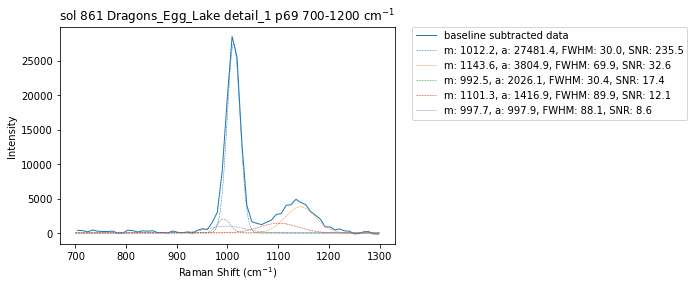

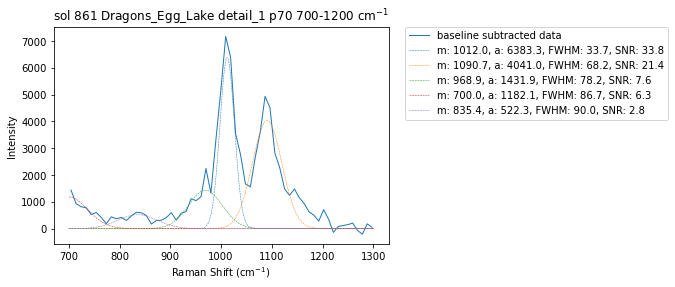

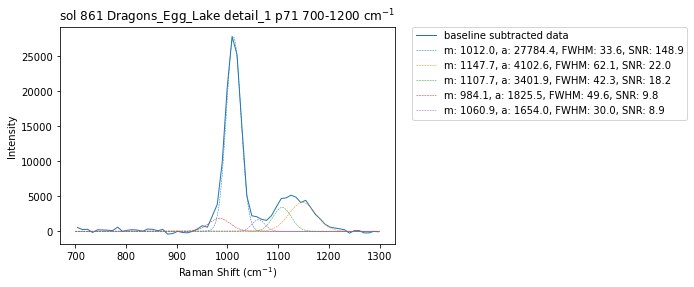

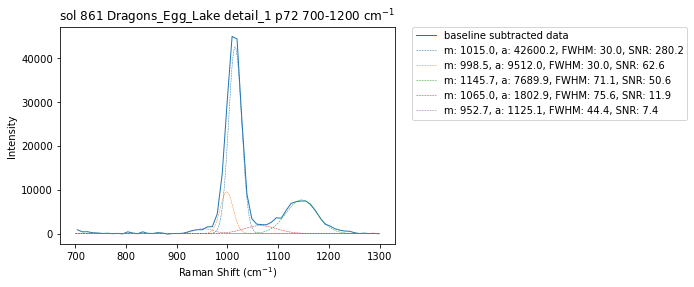

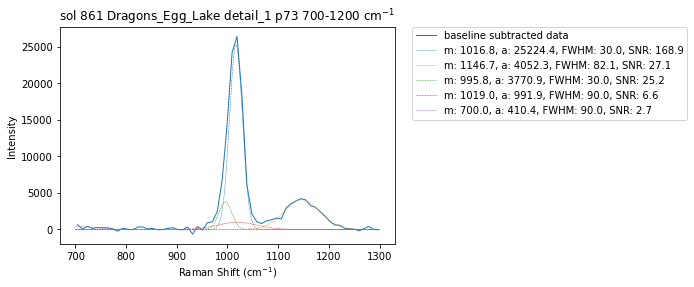

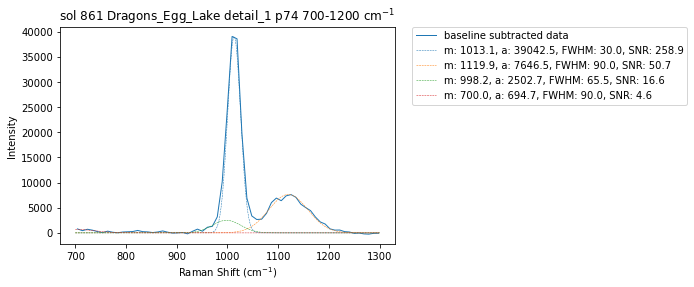

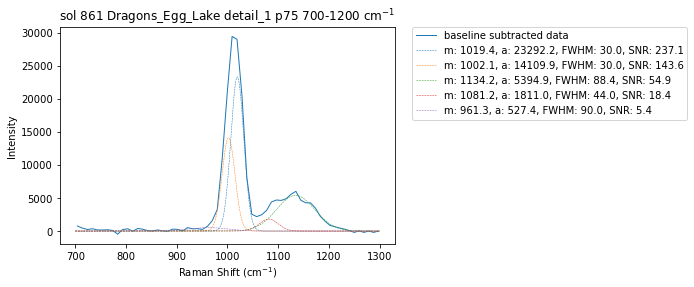

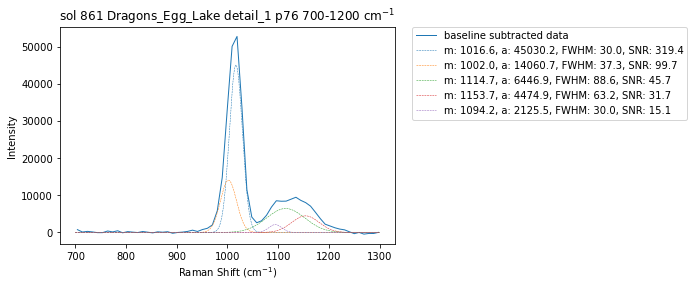

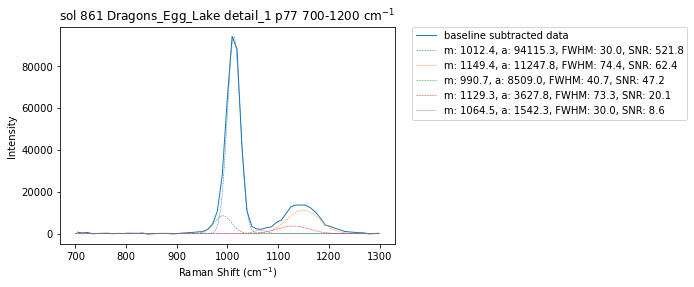

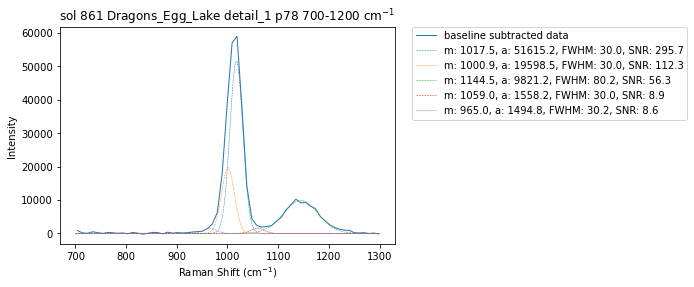

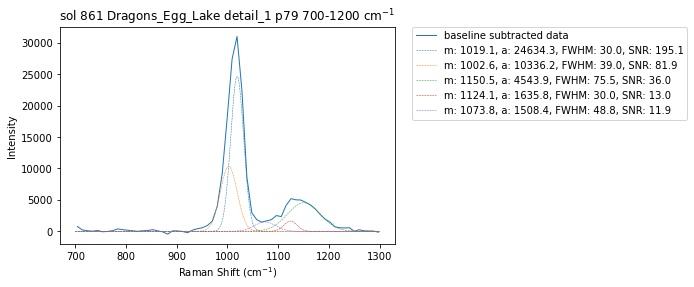

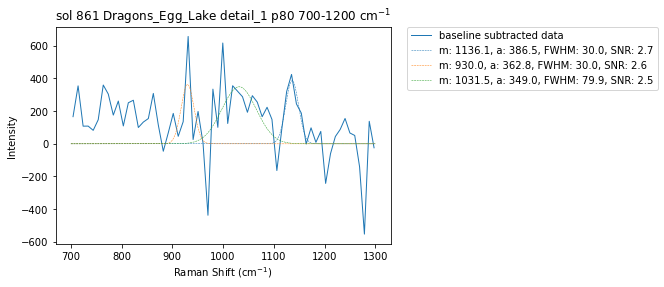

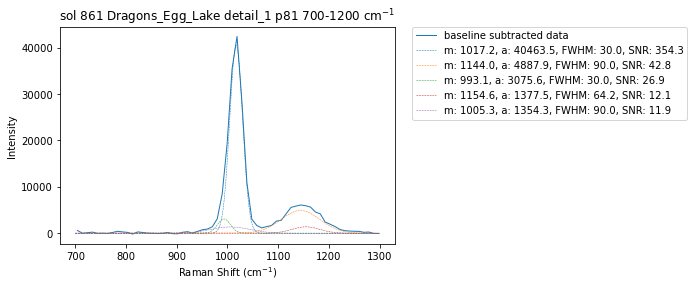

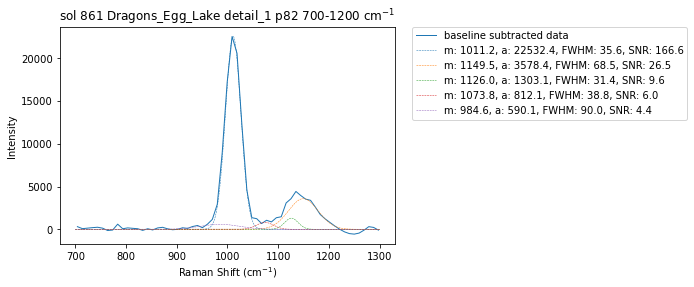

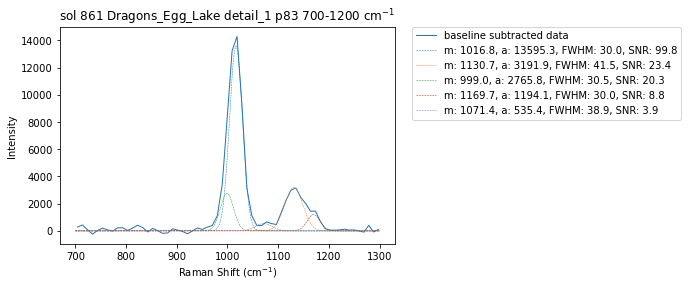

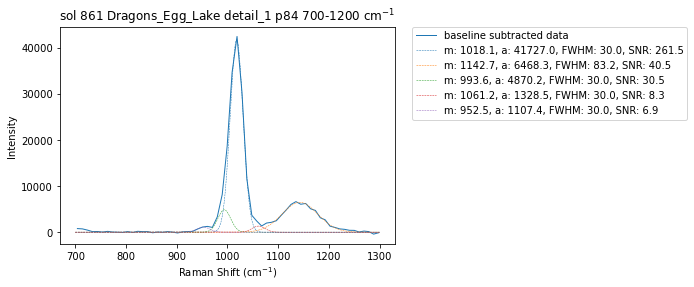

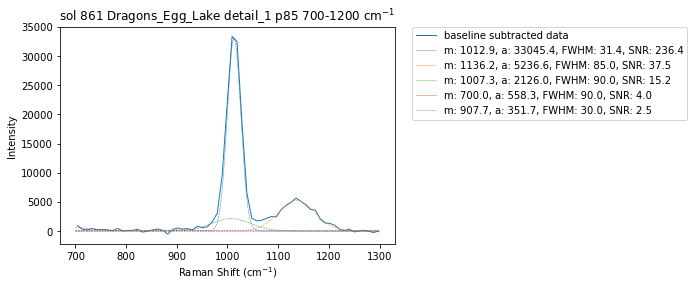

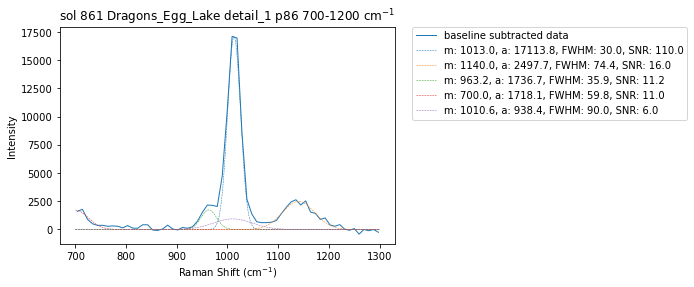

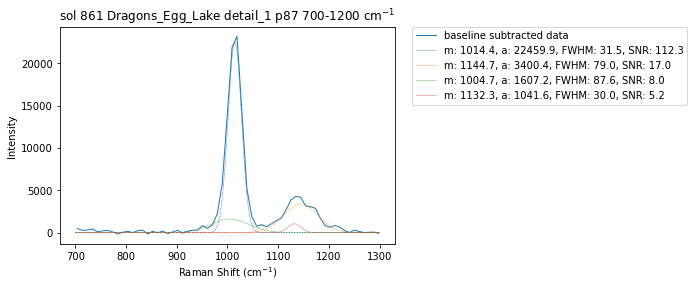

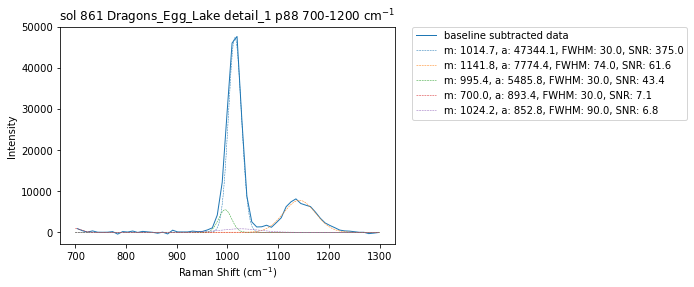

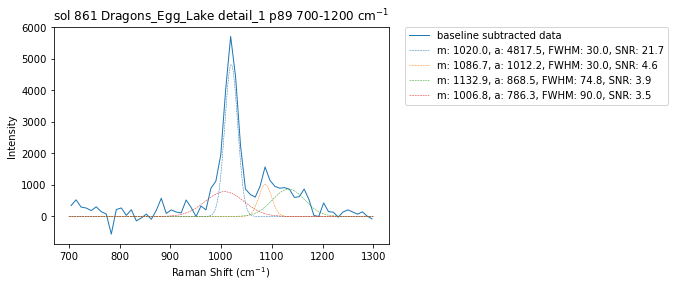

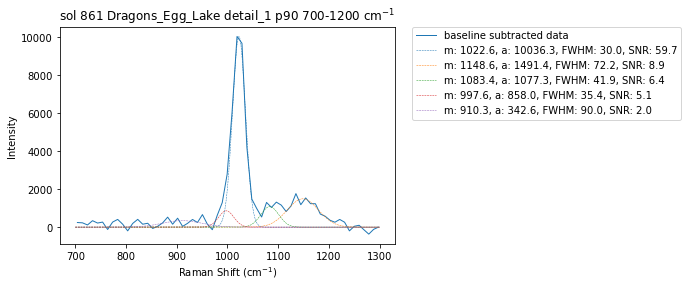

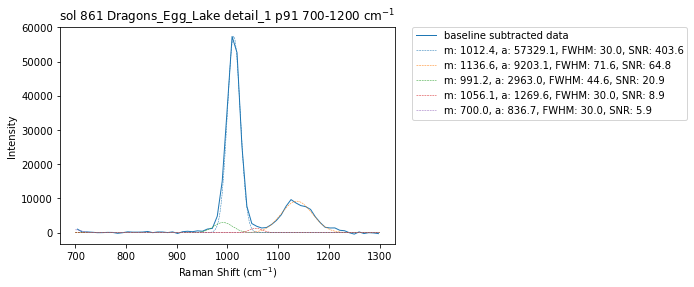

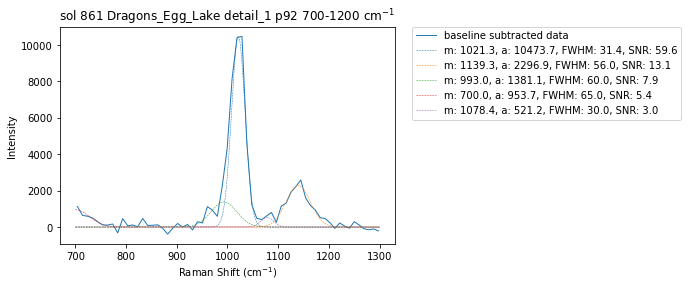

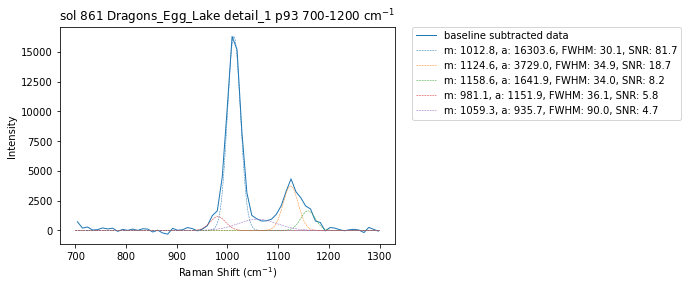

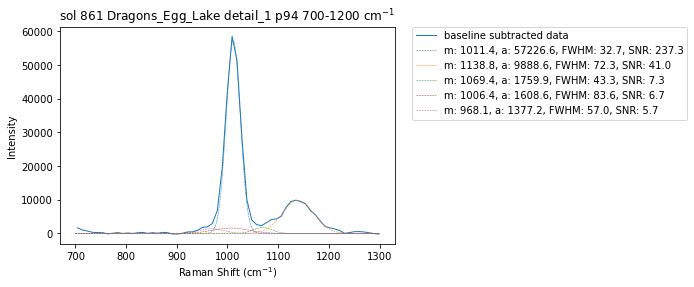

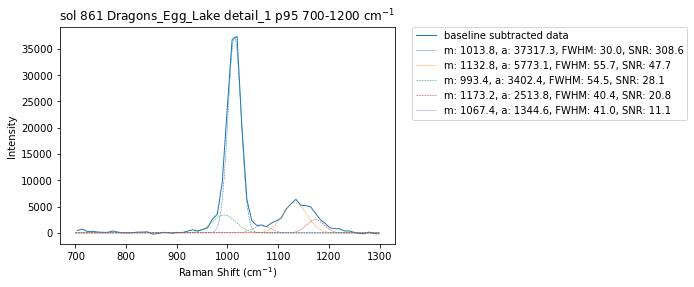

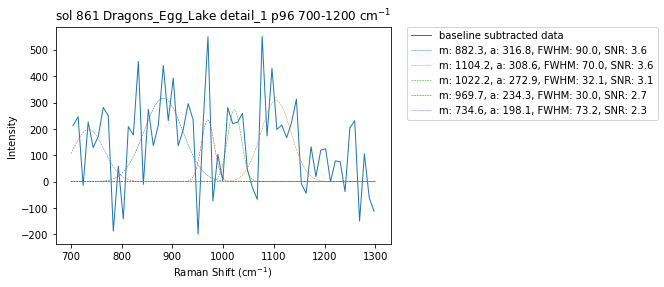

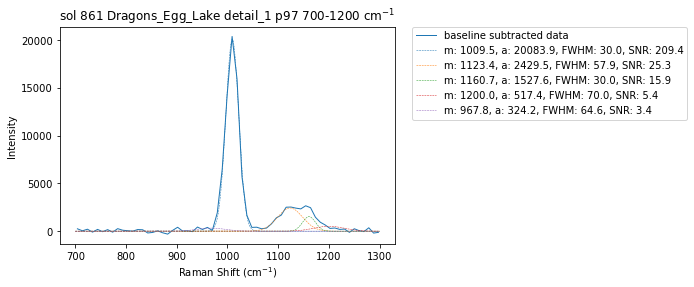

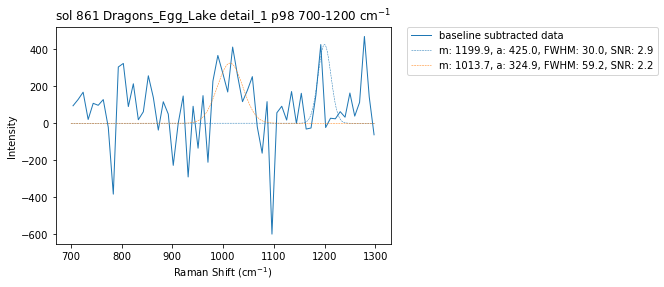

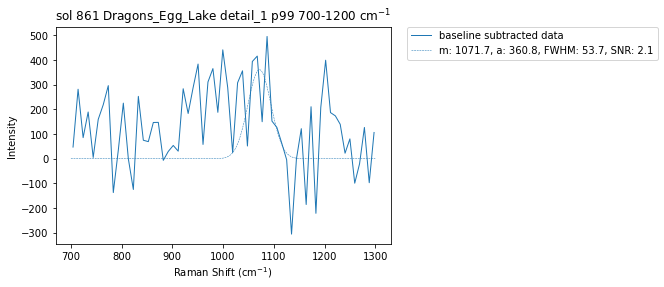

In [10]:
### 4. EXPERIMENTAL MULTIFIT CODE

# Choose the data file for peak fitting. R1_raw_baselined contains the baseline-subtracted spectra without cosmic ray removal (that can remove or otherwise affect Raman peaks).

multi_fit_data = pd.read_csv(output_dir + "/" + str(sol) + '_' + str(target) + '_' + scan + '_' + 'R1_raw_baselined.csv', index_col=0)

# Define the parameters for peak fitting.

fit_range = (700, 1200) # spectral range over which peak fitting will occur (in cm-1)
plot_range = (700, 1300) # spectral range for plotting fitted peaks
fwhm_range = (30, 90) # acceptable (min, max) FWHM for peaks
noise_wavenumber_range = (2000, 2100) # "quiet" region for calculating noise
max_peaks = 5 # maximum number of peaks that can be fit within fit_range

# define the Gaussian function

def gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        x0 = params[i + 1]
        sigma = params[i + 2]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# define (optional) FWHM penalty function to penalize (by a penalty_factor) fits that have FWHM outside the bounds of pref_range(min, max)

def fwhm_penalty(fwhm, pref_range=(40, 70), penalty_factor=300):
    if pref_range[0] <= fwhm <= pref_range[1]:
        return 0
    return penalty_factor * min(abs(fwhm - pref_range[0]), abs(fwhm - pref_range[1]))

# define (optional) separation penalty to penalize (by a penalty_factor) fits that have peaks with mean values closer than min_separation

def separation_penalty(params, min_separation=25, penalty_factor=1000):
    penalty = 0
    for i in range(3, len(params), 3):
        x0_1 = params[i - 2]
        x0_2 = params[i + 1]
        separation = abs(x0_1 - x0_2)
        if separation < min_separation:
            penalty += penalty_factor * (min_separation - separation)
    return penalty

# define the main peak fitting algorithm

def find_best_gaussian_peaks(column_data, fit_range, fwhm_range, max_peaks):
    x = column_data.index.values
    y = column_data.values
    best_params = None
    best_score = float('inf')

    for num_peaks in range(1, max_peaks + 1):
        bounds = []
        for _ in range(num_peaks):
            bounds.extend([(0, y.max()), fit_range, 
                           (fwhm_range[0] / (2 * np.sqrt(2 * np.log(2))), fwhm_range[1] / (2 * np.sqrt(2 * np.log(2))))])

        # Define the objective function to minimize
        def objective_function(params):
            residual = y - gaussian(x, *params)
            fwhm_penalty_value = 0
            separation_penalty_value = separation_penalty(params)
            for i in range(0, len(params), 3):
                a, x0, sigma = params[i], params[i + 1], params[i + 2]
                fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma
                fwhm_penalty_value += fwhm_penalty(fwhm)
            return np.sum(residual**2) + fwhm_penalty_value + separation_penalty_value

        # Optimize the objective function using differential_evolution
        try:
            result = differential_evolution(objective_function, bounds)
        except RuntimeError:
            print("The optimization process did not converge for column ", column_idx)
            continue  # Skip to the next iteration
        except Exception as e:
            print("An unexpected error occurred during optimization for column ", column_idx, ":", str(e))
            continue  # Skip to the next iteration
        
        popt = result.x
        score = result.fun

        if score < best_score:
            best_params = popt
            best_score = score

    return best_params

# Initialize DataFrames to store fitted peak parameters
multipeaks = pd.DataFrame(columns=['sol', 'target', 'scan', 'point', 'mean', 'amplitude', 'fwhm', 'snr'])

# Initialize tqdm progress bar
# progress_bar = tqdm(range(multi_fit_data.shape[1]), desc='processing columns')

# Create subfolder for plots
subfolder = f"{output_dir}/{sol}_{scan}_multifits"
if not os.path.exists(subfolder):
    os.makedirs(subfolder)
    
# Iterative fitting and plotting for all spectra in a scan

for column_idx in range(multi_fit_data.shape[1]):
    column_data = multi_fit_data.iloc[:, column_idx]

    # Calculate point_noise
    noise_data = column_data.loc[noise_wavenumber_range[0]:noise_wavenumber_range[1]]
    point_noise = noise_data.std()

    best_params = find_best_gaussian_peaks(column_data.loc[fit_range[0]:fit_range[1]], fit_range, fwhm_range, max_peaks)

    # Plot the original data and the fitted Gaussian peaks
    plt.figure()
    plt.plot(column_data.loc[plot_range[0]:plot_range[1]].index, 
             column_data.loc[plot_range[0]:plot_range[1]], label='baseline subtracted data', linewidth=1)

    x_values = np.linspace(plot_range[0], plot_range[1], 1000)

    # Use a color cycle to get different colors for each peak
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Add labels for each peak to the legend
    peak_info_list = []
    for i in range(0, len(best_params), 3):
        a, x0, sigma = best_params[i], best_params[i + 1], best_params[i + 2]
        fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma
        snr = a / point_noise
        
        if snr > 2:
            peak_info_list.append({'a': a, 'x0': x0, 'sigma': sigma, 'fwhm': fwhm, 'snr': snr})

    # Sort peak_info_list by SNR
    peak_info_list = sorted(peak_info_list, key=lambda x: x['snr'], reverse=True)

    labels = ['baseline subtracted data']
    for i, peak_info in enumerate(peak_info_list):
        y_values = gaussian(x_values, peak_info['a'], peak_info['x0'], peak_info['sigma'])
        plt.plot(x_values, y_values, '--', linewidth=0.5, color=colors[i % len(colors)])
        labels.append(f'm: {peak_info["x0"]:.1f}, a: {peak_info["a"]:.1f}, FWHM: {peak_info["fwhm"]:.1f}, SNR: {peak_info["snr"]:.1f}')

        peak_data = {'sol': sol, 'target': target, 'scan': scan, 
                     'point': column_idx, 'mean': peak_info['x0'], 'amplitude': peak_info['a'], 'fwhm': peak_info['fwhm'], 'snr': peak_info['snr']}
        multipeaks = pd.concat([multipeaks, pd.DataFrame([peak_data], columns=multipeaks.columns)], ignore_index=True)

    plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'sol {sol} {target} {scan} p{column_idx} {fit_range[0]}-{fit_range[1]} cm$^{{-1}}$')
    plt.xlabel('Raman Shift (cm$^{-1}$)')
    plt.ylabel('Intensity')

    filename = f"{subfolder}/{sol}_{target}_{scan}_{column_idx}_{fit_range[0]}_{fit_range[1]}_fits.png"

    # Export 300 dpi png
    plt.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()

# Sort fitted peak parameters by SNR, save and export as csv
multipeaks.sort_values(['snr'], ascending=False, inplace=True)
multipeaks_filename = f"{output_dir}/{sol}_{target}_{scan}_multifits.csv"
multipeaks.to_csv(multipeaks_filename, index=False)

# Assigning preliminary identifications to the peaks fit in the previous step.
Preliminary mineral class identifications are applied based on the mean value for each of the peaks modeled in the previous step. These identifications are not conclusive, and should be considered very carefully, but can be useful for rapid, automated, preliminary interpretation of SHERLOC data by mapping detections of peaks within spectral ranges where common minerals are known to occur. Olivine minerals produce peaks around 850 cm$^{-1}$, but so to does hydrated silica. Phosphate yields a peak around 970 cm$^{-1}$, but so to does perchlorate.  The range for pyroxene (~1000 cm$^{-1}$) overlaps with some sulfate minerals. SHERLOC observes diversity in sulfate mineralogy, with the $v_1$ peak for Ca-sulfates (e.g. anhydrite) occuring at lower wavenumbers (e.g. 1016 cm$^{-1}$, or sulf1_v1) than Mg-sulfates (e.g. 1030 cm$^{-1}$, or sulf2_v1). Strong detections of sulfate minerals often feature a $v_3$ doublet that occurs to SHERLOC as a single, broader peak around 1140 cm$^{-1}$ (sulf_v3). There also appears to be some spectral diversity among carbonates, and these are divided somewhat arbitrarily into lo-carb and hi-carb over the regions 1055-1075 cm$^{-1}$ and 1075 to 1105 cm$^{-1}$, respectively. It should be noted that hydrated silica may produce a peak around 1060 cm$^{-1}$, in the range of lo-carb. 

These categories are defined below, and assingments are made to the peaks fit in the previous step and the resulting data are exported in a new csv and appended to a master file. 

Beyond this point, the next processing steps require manual inspection of peaks to eliminate spurious fits and compositional mapping of preliminary mineral categories. This is achieved using a different notebook, called SHERLOC_DPP_PDS_manual_KHW.ipynb.

In [11]:
# Read the multifits.csv file into a DataFrame
multifits = pd.read_csv(f"{output_dir}/{sol}_{target}_{scan}_multifits.csv")

# Define a function to assign IDs based on the mean value
def assign_id(mean_value):

    if 820 <= mean_value <= 860:
        return "olivine"
    elif 950 < mean_value <= 980:
        return "phosphate"
    elif 980 < mean_value <= 1009:
        return "pyroxene"
    elif 1009 < mean_value <= 1020:
        return "sulf1_v1"
    elif 1020 < mean_value <= 1045:
        return "sulf2_v1"
    elif 1045 < mean_value <= 1055:
        return "1050"
    elif 1055 < mean_value <= 1075:
        return "lo-carb"
    elif 1075 < mean_value <= 1105:
        return "hi-carb"
    elif 1120 <= mean_value <= 1135:
        return "sulf_v3"
    else:
        return "unidentified"

# Create a new column 'min_ID' and populate it using the assign_id function
multifits["min_ID"] = multifits["mean"].apply(assign_id)

# Sort the DataFrame by 'point' and then by 'mean'
multifits.sort_values(by=['point', 'mean'], ascending=True, inplace=True)

# Add a new column 'peak_ID' and populate it with a sequence of increasing integers
multifits['peak_ID'] = range(1, len(multifits) + 1)

# Save the updated DataFrame with ID column to a new CSV file
multifits_ID_filename = f"{output_dir}/{sol}_{target}_{scan}_multifits_ID.csv"
multifits.to_csv(multifits_ID_filename, index=False)

# Create a new column 'master_ID'
multifits['master_ID'] = multifits.apply(lambda row: f"{sol}_{target}_{scan}_f{row['peak_ID']}", axis=1)

# Check if the master file already exists
if os.path.isfile('SHERLOC_multifits_ID_master.csv'):
    # Append without the header (mode='a' is for append)
    multifits.to_csv('SHERLOC_multifits_ID_master.csv', mode='a', header=False, index=False)
else:
    # Write with the header for the first time
    multifits.to_csv('SHERLOC_multifits_ID_master.csv', index=False)